In [2]:
import random
import numpy as np
from tqdm import tqdm
from PIL import Image
from pathlib import Path
from itertools import islice
import matplotlib.pyplot as plt

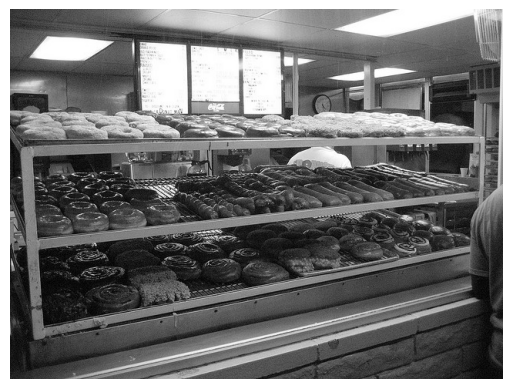

In [3]:
img_dir = Path.cwd() / "images"
img = Image.open(img_dir / "real" / "0001.jpg").convert("L")
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [4]:
def preprocess_imgs(input_dir, output_dir, dims=(256,256), total=None):
    output_dir.mkdir(exist_ok=True)

    img_paths = sorted(input_dir.glob("*.jpg"), key=lambda p: int(p.stem))
    pbar = tqdm(total=total if total is not None else len(img_paths))
    count = 0

    for img_path in img_paths:
        pbar.update(1)
        # We have to handle total this way because we don't know how many images will be skipped
        if total is not None and count >= total:
            break

        with Image.open(img_path) as img:
            img = img.convert("L")
            w, h = img.size

            # Sort out images smaller than desired in any of dimensions
            if w < dims[0] or h < dims[1]:
                continue

            w_start = random.randint(0, w - dims[0])
            h_start = random.randint(0, h - dims[1])

            # left, top, right, bottom
            cropped_img = img.crop((w_start, h_start, w_start + dims[0], h_start + dims[1]))
            cropped_img.save(output_dir / f"{img_path.stem}.jpg")

            count += 1
            
    pbar.close()

In [5]:
# # With default total=None, process all images in the folders
# preprocess_imgs(img_dir / "real", img_dir / "real_proc")
# preprocess_imgs(img_dir / "gen", img_dir / "gen_proc")

In [6]:
def calc_magnitude_spect(img):
    # 2D FFT of the image array
    fft = np.fft.fft2(img)
    fft_shifted = np.fft.fftshift(fft)  # Move zero frequency to center

    # Magnitude spectrum
    mag = np.abs(fft_shifted)
    mag_log = np.log1p(mag)  # Log scale for visibility

    return mag_log

In [7]:
def calc_radial_prof(arr):    
    # Calculate radial distances from the image centre
    h, w = arr.shape
    rows, cols = np.indices((h, w))
    cy = (h - 1) / 2
    cx = (w - 1) / 2
    radial_dists = np.sqrt((rows - cy)**2 + (cols - cx)**2)
    r = radial_dists.astype(int)

    # Calculate sum of pixel values at a certain radius and divide by number of bins at that radius
    sum_bins = np.bincount(r.ravel(), weights=arr.ravel())
    num_bins = np.bincount(r.ravel())
    radial_prof = sum_bins / num_bins

    return radial_prof

In [8]:
def get_rp_arrays(img_dir, total=None):
    rps = []
    img_paths = islice(img_dir.glob("*.jpg"), total)

    for img_path in img_paths:
     
        img = Image.open(img_path)
        rp = calc_radial_prof(calc_magnitude_spect(img))
        rps.append(rp)
  
    return rps

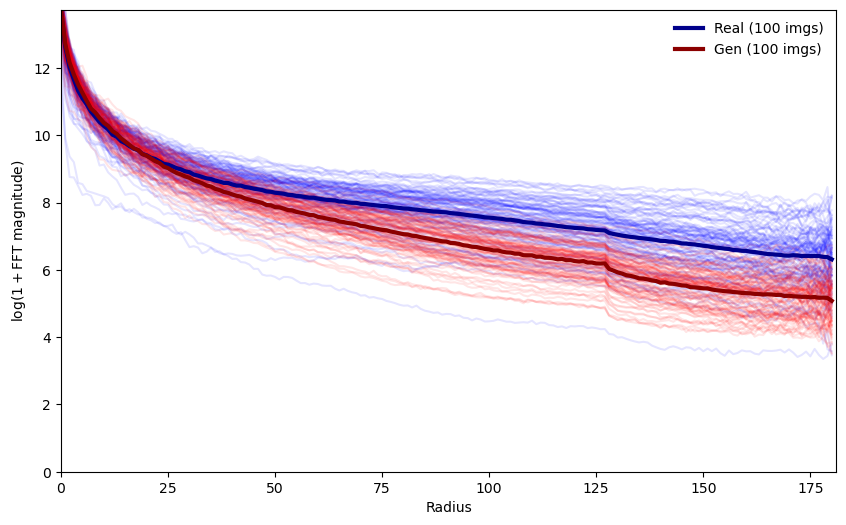

In [9]:
rps_real = get_rp_arrays(img_dir / "real_proc", total=100)
rps_gen = get_rp_arrays(img_dir / "gen_proc", total=100)

plt.figure(figsize=(10,6))

for rp in rps_real:
    plt.plot(rp, color='b', alpha=0.1)

for rp in rps_gen:
    plt.plot(rp, color='r', alpha=0.1)

# Plot array-wise averages of the 2D array
rp_real_avg = np.mean(rps_real, axis=0)
rp_gen_avg = np.mean(rps_gen, axis=0)

plt.plot(rp_real_avg, color='darkblue', linewidth=3, label=f"Real ({len(rps_real)} imgs)")
plt.plot(rp_gen_avg, color='darkred', linewidth=3, label=f"Gen ({len(rps_gen)} imgs)")
plt.ylim(0, max(rp_real_avg.max(), rp_gen_avg.max()))
plt.xlim(0, len(rp_real_avg))
plt.legend(frameon=False)
plt.ylabel(r"$\log(1 + \text{FFT magnitude})$")
plt.xlabel("Radius")
plt.show()

FFT shifts image data from the spatial into the frequency domain. By decomposing the image into its constituent sinusoidal components, we get a magnitude spectrum where the centre represents low-frequencies (slow transitions, shapes) and the periphery represents high-frequencies (fine details, noise, edges). The radial profile is then calculated by averaging the magnitude values at each radius from the centre.

A drop in both curves at radius 128 is a border effect, as beyond that radius, higher radius samples will only be limited to the diagonal corners, and diagonals in natural images typically contain less energy than the axes.

https://www.mdpi.com/2078-2489/15/11/711

# CNN

In [10]:
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

In [11]:
total = 1000

real_dir = Path.cwd() / "images" / "real_proc"
gen_dir = Path.cwd() / "images" / "gen_proc"

# Take images from the start of the sorted list to keep dataset balanced
# key is a function to execute to decide the order
# .stem works only with pathlib objects
real_paths = list(sorted(real_dir.glob("*.jpg"), key=lambda p: int(p.stem)))[:total]
gen_paths = list(sorted(gen_dir.glob("*.jpg"), key=lambda p: int(p.stem)))[:total]

df_real = pd.DataFrame({"path": real_paths, "label": 0})
df_gen = pd.DataFrame({"path": gen_paths, "label": 1})
df_all = pd.concat([df_real, df_gen], ignore_index=True)

pd.set_option('display.max_colwidth', None)
display(df_all.head())

,path,label
0,Path.cwd() /images/real_proc/0000.jpg,0
1,Path.cwd() /images/real_proc/0001.jpg,0
2,Path.cwd() /images/real_proc/0002.jpg,0
3,Path.cwd() /images/real_proc/0003.jpg,0
4,Path.cwd() /images/real_proc/0004.jpg,0


In [12]:
df_train, df_temp = train_test_split(df_all, test_size=0.3, stratify=df_all["label"], random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp["label"], random_state=42)

In [13]:
class ImageDataset(Dataset):
    """
    DataLoader calls df[i], which in pandas looks up a column, not a row. It requires a Dataset
    where __getitem__ uses positional indexing via .iloc, or data converted to tensors/ arrays
    (preloading all images, unlike a Dataset class which loads and transforms them on the fly).
    __len__ is needed to know the number of samples.
    """
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        path = self.df.loc[i, "path"]
        label = self.df.loc[i, "label"]

        img = Image.open(path)
        img = np.array(img, dtype=np.float32) / 255.0
        img = torch.from_numpy(img).unsqueeze(0)

        return img, label

In [14]:
train_ds = ImageDataset(df_train)
val_ds = ImageDataset(df_val)
test_ds  = ImageDataset(df_test)

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [15]:
class SimpleCNN(nn.Module):
    """
    1st layer: 1 input channel (greyscale image), 16 output channels (feature maps),
    3×3 kernels initialised randomly and learned during training.
    
    params = (input channels * kernel height * kernel width + bias) * output channels,
    e.g.: (1 * 3 * 3 + 1) * 16 = 160
          (16 * 3 * 3 + 1) * 32 = 4640

    nn.MaxPool2d(2, 2) has kernel size 2×2 and stride 2×2, reduces spacial dims by half.

    self.fc1 maps 3a flattened 2 * 64 * 64 array to 128 neurons
    self.fc2 maps 128 neurons to 2 output classes
    """
    def __init__(self):
        # super() in Python calls methods of a parent class
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding="same")
        self.conv2 = nn.Conv2d(16, 32, 3, padding="same")
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [16]:
# -1 is a placeholder for the batch size
model = SimpleCNN()
summary(model, input_size=(1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             160
         MaxPool2d-2         [-1, 16, 128, 128]               0
            Conv2d-3         [-1, 32, 128, 128]           4,640
         MaxPool2d-4           [-1, 32, 64, 64]               0
            Linear-5                  [-1, 128]      16,777,344
            Linear-6                    [-1, 2]             258
Total params: 16,782,402
Trainable params: 16,782,402
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/backward pass size (MB): 15.00
Params size (MB): 64.02
Estimated Total Size (MB): 79.27
----------------------------------------------------------------


In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
n_epochs = 20

model = SimpleCNN().to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.0001)
crit = nn.CrossEntropyLoss()

# Set up lists to track loss
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    # Set model to training mode
    model.train()
    train_loss = 0.0

    for bat_x, bat_y in train_loader:
        bat_x, bat_y = bat_x.to(device), bat_y.to(device)

        # Forward pass
        outputs = model(bat_x) # Randomly initialised by PyTorch by default the first time it runs
        loss = crit(outputs, bat_y)

        # Backward pass
        optim.zero_grad()   # Clear previous gradients
        loss.backward()     # Compute gradients
        optim.step()        # Update parameters

        train_loss += loss.item()

    # Record average training loss for this epoch
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Set model to evaluation mode and evaluate on the validation set
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for bat_x, bat_y in val_loader:
            bat_x, bat_y = bat_x.to(device), bat_y.to(device)

            outputs = model(bat_x)
            loss = crit(outputs, bat_y)

            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch + 1:>2}/{n_epochs}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}")

Epoch  1/20, train loss: 0.7083, val loss: 0.6737
Epoch  2/20, train loss: 0.6464, val loss: 0.6315
Epoch  3/20, train loss: 0.6150, val loss: 0.6014
Epoch  4/20, train loss: 0.5616, val loss: 0.5599
Epoch  5/20, train loss: 0.5133, val loss: 0.5240
Epoch  6/20, train loss: 0.4814, val loss: 0.5089
Epoch  7/20, train loss: 0.4504, val loss: 0.4972
Epoch  8/20, train loss: 0.4306, val loss: 0.4895
Epoch  9/20, train loss: 0.4175, val loss: 0.4831
Epoch 10/20, train loss: 0.4104, val loss: 0.4751
Epoch 11/20, train loss: 0.3965, val loss: 0.4694
Epoch 12/20, train loss: 0.3708, val loss: 0.4675
Epoch 13/20, train loss: 0.3592, val loss: 0.4606
Epoch 14/20, train loss: 0.3401, val loss: 0.4616
Epoch 15/20, train loss: 0.3262, val loss: 0.4592
Epoch 16/20, train loss: 0.3241, val loss: 0.5101
Epoch 17/20, train loss: 0.3217, val loss: 0.4833
Epoch 18/20, train loss: 0.2957, val loss: 0.4896
Epoch 19/20, train loss: 0.2939, val loss: 0.4495
Epoch 20/20, train loss: 0.2641, val loss: 0.4528


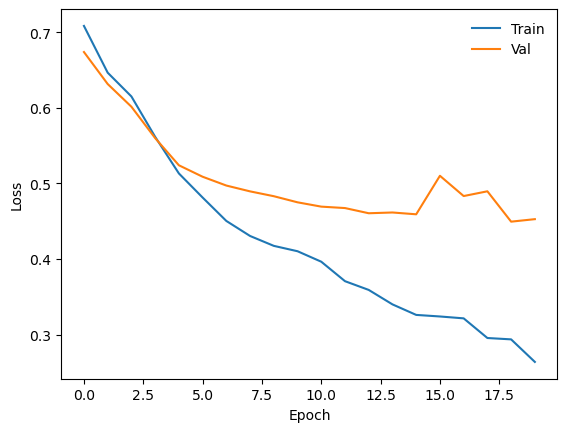

In [19]:
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.legend(frameon=False)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [20]:
y_true, y_pred, y_pred_prob = [], [], []
model.eval()

with torch.no_grad():
    for bat_x, bat_y in test_loader:
        bat_x, bat_y = bat_x.to(device), bat_y.to(device)

        logits = model(bat_x)
        y_pred_bat = torch.argmax(logits, 1)
        y_pred_prob_bat = torch.softmax(logits, dim=1)[:, 1]

        y_true.append(bat_y.cpu().numpy())
        y_pred.append(y_pred_bat.cpu().numpy())
        y_pred_prob.append(y_pred_prob_bat.cpu().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
y_pred_prob = np.concatenate(y_pred_prob)

In [21]:
cm = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred)

print(f"Confusion matrix:\n{cm}")
print(f"Accuracy: {acc:.3f}")
print(f"F1 Score: {f1:.3f}")

Confusion matrix:
[[108  42]
 [ 17 133]]
Accuracy: 0.803
F1 Score: 0.818
